In [68]:
import pickle as pkl

In [69]:
filename = "sim_results/market-marl-nash-3-04-17-2022-02-32-30110_results.pkl"

with open(filename, 'rb') as f:
    res = pkl.load(f)


In [70]:
res.losses

array([4.89583015, 4.85328007, 4.8114996 , 4.9047699 , 4.84860659,
       4.77043486, 4.80439568, 4.88134813, 4.73776007, 4.74039078])

In [71]:
l = list(dir(res))

In [72]:
import numpy as np
import seaborn as sns

In [73]:
res.losses

array([4.89583015, 4.85328007, 4.8114996 , 4.9047699 , 4.84860659,
       4.77043486, 4.80439568, 4.88134813, 4.73776007, 4.74039078])

In [74]:
import pandas as pd

sns.set_theme(style="darkgrid")
data_losses = {"Q Function Loss": res.losses, "Epsilon Function Loss": res.losses_eps}
data_losses_df = pd.DataFrame(data=data_losses)
# sns.lineplot(data=data_losses_df)

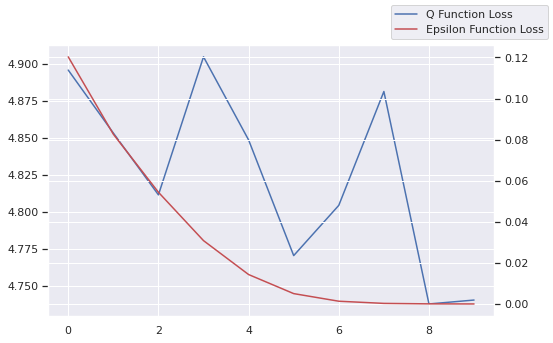

In [75]:
# import matplotlib.pyplot as plt

ax = data_losses_df.plot(y="Q Function Loss", legend=False, figsize=(8, 5))
ax2 = ax.twinx()
data_losses_df.plot(y="Epsilon Function Loss", ax=ax2, legend=False, color="r")
ax.figure.legend()


In [76]:
# import matplotlib.pyplot as plt
# sns.lineplot(data=res.losses, color="b", legend="auto")
# ax2 = plt.twinx()
# sns.lineplot(data=res.losses_eps, color="g", ax=ax2)


In [77]:
# Plot rewards

data_rewards = {"Average Agent Reward": res.avg_epoch_rewards, "Average Reward for Agent 0": res.avg_epoch_rewards_agent}
data_rewards_df = pd.DataFrame(data=data_rewards)

<AxesSubplot:>

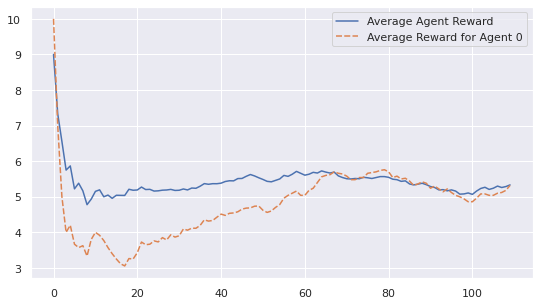

In [78]:
sns.set(rc={'figure.figsize':(9, 5)})
sns.lineplot(data=data_rewards_df)

In [79]:
state_key = [0.0, 0.0, 0.0, 8.0]

res.sna_policy_dict_iter[repr(state_key)][0][9]

0.1

In [80]:
max_p = 0
agent_id = 0
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)

0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0


In [81]:
max_p = 0
agent_id = 1
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0


In [82]:
max_p = 0
agent_id = 2
for x in range(10):
    p = res.sna_policy_dict_iter[repr(state_key)][agent_id][x]
    if p > max_p:
        max_p = p
        max_x = x
    print(p)
print(max_x)
    

0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0
